# Projet Datascientest | DST_DEC22 | Rapport de modélisation

**Participants** : Olga TOLSTOLUTSKA, Mohamed BACHKAT, Charly LAGRESLE \
**Mentor** : Manu PORTEL \
**Date du document** : 2023/02/20

## Contexte et objectif

Rakuten est un site de e-commerce, regroupant près de 1.3 milliards d'utilisateurs. Afin de faciliter la gestion des suggestions de leurs recherches ou des recommandations qui leurs seront proposées, il est important de classifier les produits. Du fait de la quantité de produits et de leurs catégories associées, ce classement ne peut ni être fait manuellement, ni être régi par des règles. Une approche plus flexible, efficace et reproductible est donc à mettre en place. 

L'objectif est de prédire le code de chaque produit, c'est-à-dire sa catégorie, sur la base d'une analyse de données textuelles et d'images.



## Prérequis

### Equilibrage : 
Random Under Sampling 84916 -> 17523 soit 656 produits par catégorie \
Random Over Sampling 84916 -> Pas encore effectué

### Choix des métriques

Jeu ré-équilibré \
F1-score \
Recall \
Accuracy

### Feature-engineering

#### Texte

Via trois pipelines :
* Chargement
* Traduction
* Vectorisation

#### Image

Crop :


## Modèles simples

### Texte

MAX_FEATURES_WORDS = 10000
RandomUnderSampling

#### Mise en place des données

Action du pipeline :
* Suppression des colonnes inutiles
* Standardisation
* Classifier

#### Modèles testés

Plusieurs modèles ont été mis en place. Les modèles sont ici utilisés dans leur configuration par défaut, c'est-à-dire sans hyperparamètres. Les scores mentionnés sont la moyenne des scores pour chaque classe.

| Modèle                | Type     | Accuracy | Recall | F1-Score | Durée de l'entrainement |
|-----------------------|----------|-----------|--------|----------|-------------------------|
| LogisticRegression    | Simple   | 0.66 | 0.70 | 0.67 | 169s |
| KNC                   | Simple   | 0.53 | 0.43 | 0.41 | 28s |
| SVC                   | Simple   | Accuracy | Recall | F1-Score | Durée de l'entrainement |
| DecisionTree          | Simple   | 0.60 | 0.63 | 0.61 | 47s |
| RandomForest          | Ensemble | 0.71 | 0.74 | 0.72 | 94s |
| GradientBoosting*     | Ensemble | 0.72 | 0.72 | 0.72 | 2497s |
| AdaBoost              | Ensemble | 0.11 | 0.10 | 0.07 | 148s |




<sup><sup>*n_estimators=50 sinon trop long</sup></sup>

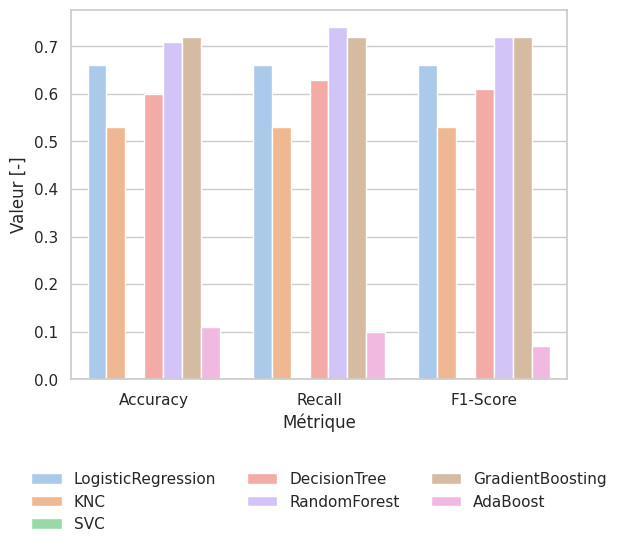

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", palette="pastel")

df = pd.DataFrame.from_dict(
    {"Modèle" : ["LogisticRegression", "KNC", "SVC", "DecisionTree", "RandomForest", "GradientBoosting", "AdaBoost"],
    "Accuracy" : [.66, .53, .0, .60, .71, .72, .11],
    "Recall" : [.66, .53, .0, .63, .74, .72, .10],
    "F1-Score" : [.66, .53, .0, .61, .72, .72, .07],
    #"Duration" : [257, 171, 0, 141, 94, 2497, 148],
    }
)
df_melted = df.melt(id_vars="Modèle", value_vars=["Accuracy", "Recall", "F1-Score"], value_name="Valeur [-]", var_name="Métrique")
sns.barplot(data=df_melted, x="Métrique", y="Valeur [-]", hue="Modèle");
plt.legend(loc='lower center', frameon=False, bbox_to_anchor=(0.5, -.45), ncol=len(df_melted.columns));


#### Optimisation des hyperparamètres

| Modèle                |  Accuracy  | Recall | F1-Score | Parameters |
|-----------------------|------------|--------|----------|------------|
| KNC                   | 0.55 | 0.39 | 0.39 | {'classifier__leaf_size': 5, 'classifier__n_neighbors': 10} |

PAS OUF, même moins bien ^^


### Image

#### Mise en place des données

Les images sont importées via un ImageDataGenerator afin de :
* ne pas les charger directement en mémoire
* appliquer un redimensionnement 
* appliquer des transformations aléatoires

/!\PAS DE SUITE, c'est du finetuning, endommage les inputs/!\

Question : faire un zoom fixe?


#### Modèles testés

##### Feature PCA  + Modèle SVC :

Dans une deuxième partie de l'étude de la modélisation par ML des images, il est opéré une SVC (avec une réduction de dimensions par PCA) car il est le modèle le plus efficace pour la reconnaissance de formes. Le score obtenu a été de 0.3. Ce score est différent de ceux d'Olga car les images sont plus nombreuses plus de 4000 images et ce qui est décisif c'est le paramètre du SVC, kernel = 'rbf'.Ce score médiocre n'est pas suffisant et un modèle plus avancé a été proposé qui est l'arbre de décision boosté. Olga qui a notamment travaillé sur les modèles de classification de ML a elle aussi obtenu des résultats non satisfaisants. Elle a quant à elle réalisé une cross validation avec des grilles et elle a travaillé sur les métriques.  En fait les modèles de classification de Machine learning ne sont pas assez puissants pour notre problèmatique de classification d'images et il faut passer au deep learning. 



La matrice de confusion en heatmap est la suivante :





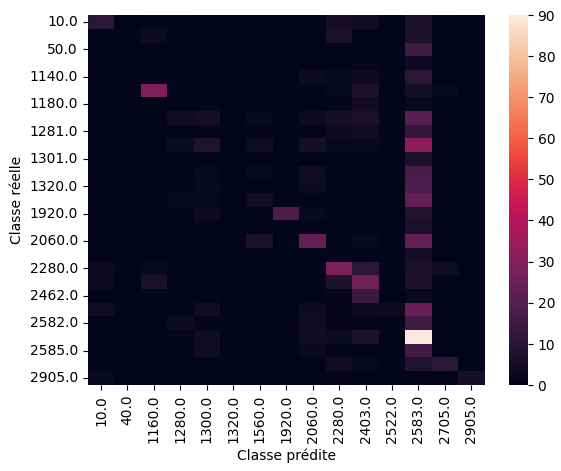

In [4]:
from IPython.display import Image
Image(filename="images/SVCHeatmap.png")

**CNN Simple** 

| Layer (type)       | Output Shape | Param |  
|--------------------|--------------|-------|
|Conv2D              |(None, 100, 100, 64) |     1792 |
|MaxPooling2D        |(None, 34, 34, 64)   |     0    |
|Dropout             |(None, 34, 34, 64)   |     0    |
|Flatten             |(None, 73984)        |     0    |
|Dense               |(None, 27)           |     1997595    |


Total params: 1,999,387 \
Trainable params: 1,999,387 \
Non-trainable params: 0


| Modèle                | Type     | Accuracy | Recall | F1-Score | Durée de l'entrainement |
|-----------------------|----------|-----------|--------|----------|-------------------------|
| CNN Simple    | CNN   | 0.66 | 0.70 | 0.67 | 169s |

ATTENTION
val_accuracy ~ 0.4
test_accuracy ~ 

## Modèles complexes

### Texte

A decider ou tester!

* Choix du modèle
    * NN
    * CNN
    * ANN
* Choix du layout
    * Choix du nombre de couches
    * Choix des dimensions
* Choix du compilateur
    * Choix de la fonction perte
    * Choix de l'optimiseur
    * Choix de la métrique

Organisation des couches du réseau de neurones testé

* Input  : X_train.shape[1] (nombre de features)
* Layer 1: 108
* Layer 2: 54
* Output : 27 (nombre de catégories)


| Modèle   |  Accuracy | Recall | F1-Score | Durée de l'entrainement |
|----------|-----------|--------|----------|-------------------------|
| NN 1     | .77   | .76 | 0.76 | 254s |


### Image

#### Modèle CNN Lenet pour les images

Il est présenté un modèle de classification par réseau de neurones pour les images. Le CNN en question est le Lenet. Les résultats sont bien meilleurs car ils avoisinent les 0.85 mais le réseau réalise de l'overfiting et la val_accuracy est faible, elle est aux environs de 0,2.L'objectif pour la remise du rapport final et de bien comprendre ce que font les couches des réseaux de neurones, par exemple detecter des rectangles plus allongés pour les livres que pour les jeux vidéos et de parcourir les images pour voir déjà à l'oeil comment la classification peut se faire et voir les problèmes rencontrés comme par exemple les personnages dans les couvertures de livres, les jeux vidéos et les jouets, comment les distinguer. Bien comprendre comment opérent les couches du CNN et bien comprendre l'interprétation des spécificités des images est la clé de bons résultats.

La matrice de confusion obtenue pour le CNN Lenet est la suivante :












## Fusion des modèles

* Même produits entrainement
* Pas les mêmes features

Methodes à notre disposition :
* Voting
* Stacking
* MultiInput
* Concatenation de la couche precendent la couche à 27 couches
* Entrainer juste les couches de derniere classification

* Rapport
* Summary
* RNN : a faire
* VGG16 transfert leaning, VGG16 penser à redimensionner les images
* FUSION
* Pousser master
* 15h demain

